In [75]:
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns
import pandas as pd
from scipy import stats
from statannotations.Annotator import Annotator

%matplotlib widget
sns.set_palette("pastel")

<h1 style="text-align:center">Dataset Loading</h1>

In [1]:
data = pd.read_excel("data/Telomere MDD.xlsx")

In [2]:
data.info(verbose=True, memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 69 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   telomere_length                64 non-null     float64
 1   age                            64 non-null     int64  
 2   sex                            64 non-null     int64  
 3   civil_status                   64 non-null     int64  
 4   educ_level                     64 non-null     int64  
 5   employ_stat                    64 non-null     int64  
 6   ses                            64 non-null     int64  
 7   average_sleep                  64 non-null     int64  
 8   smoking_daily_ave              64 non-null     int64  
 9   alcohol_daily_ave              64 non-null     int64  
 10  prohibited_drug                64 non-null     int64  
 11  prohibited_drug_type           64 non-null     int64  
 12  fruit_veg                      64 non-null     int64

<h1 style="text-align:center">Sex & Age vs. Telomere Length</h1>

In [65]:
age = data["age"]
sex = data["sex"]
sex_labels = sex.map({1:"Male", 2:"Female"})
telomere_length = data["telomere_length"]

<h2>Age vs. Telomere Length Linear Regression</h2>

In [14]:
a_tl_linreg = stats.linregress(x=age, y=telomere_length)

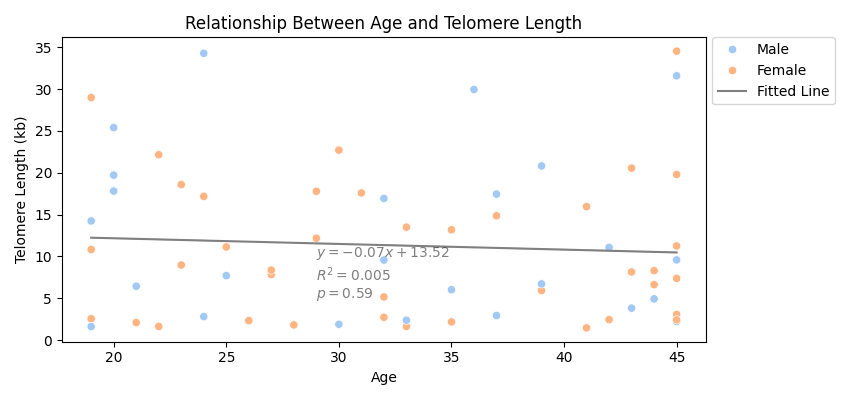

In [78]:
age_vs_tl_fig, age_vs_tl_axis = plt.subplots(1,1, figsize=(8.5,4))
age_vs_tl_axis.set(title="Relationship Between Age and Telomere Length",
                   xlabel="Age", ylabel="Telomere Length (kb)")

sns.scatterplot(x=age, y=telomere_length, hue=sex_labels, ax=age_vs_tl_axis)

sns.lineplot(x=age, y=(a_tl_linreg.slope*age+a_tl_linreg.intercept), label="Fitted Line", ax=age_vs_tl_axis,
             color="gray")

age_vs_tl_axis.text(x=29, y=5,
                    s=f"$y={a_tl_linreg.slope:.2f}x+{a_tl_linreg.intercept:.2f}$"
                    f"\n$R^{2} = {a_tl_linreg.rvalue**2:.3f}$"
                    f"\n$p = {a_tl_linreg.pvalue:.2f}$",
                    alpha=0.5)


age_vs_tl_axis.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

age_vs_tl_fig.tight_layout()
age_vs_tl_fig.savefig("figures/Age vs. Telomere Length (Linear Regression).png", dpi=300)

<h2>Telomere Length Variation By Sex</h2>

<h3>Test for Normality (Shapiro-Wilk Test)</h3>

In [86]:
sex_tl_temp = data[["sex", "telomere_length"]].copy()
sex_tl_temp["sex"] = sex_labels
pg.normality(data=sex_tl_temp, dv="telomere_length", group="sex", method="shapiro")

,W,pval,normal
sex,,,
Male,0.884849,0.008714,False
Female,0.906191,0.003336,False


<h3>Test for Homoscedasticity (Levene's Test)</h3>

In [90]:
pg.homoscedasticity(data=sex_tl_temp, dv="telomere_length", group="sex", method="levene")

,W,pval,equal_var
levene,0.877211,0.352601,True


<h3>Group Comparison (Mann-Whitney Test) & Visualization</h3>

c:\Users\barbie\Desktop\telomere-mental-health\.venv\Lib\site-packages\statannotations\Annotator.py:786: UserWarning: Changing alpha without updating pvalue_thresholds can result in inconsistent plotting results
  warnings.warn("Changing alpha without updating "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Male vs. Female: Mann-Whitney-Wilcoxon test two-sided, P_val:6.203e-01 U_stat=5.240e+02


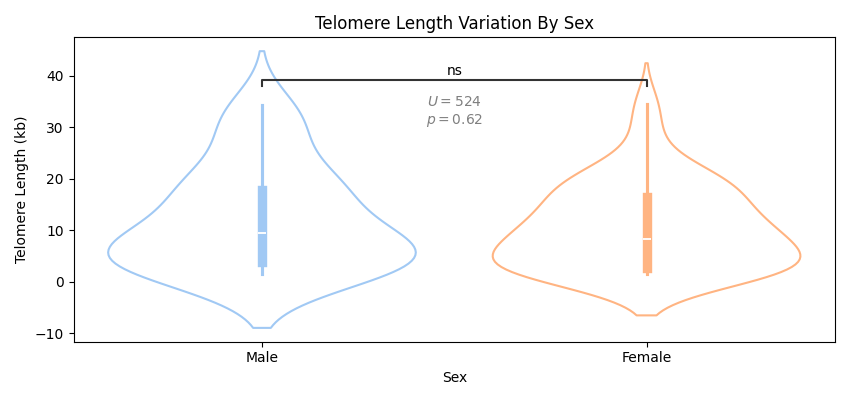

In [103]:
sex_tl_fig, sex_tl_axis = plt.subplots(1,1, figsize=(8.5,4))
sex_tl_axis.set(title="Telomere Length Variation By Sex",
                   xlabel="Sex", ylabel="Telomere Length (kb)")

sns.violinplot(x=sex_labels, y=telomere_length,hue=sex_labels,
               fill=False)


annotator = Annotator(ax=sex_tl_axis, pairs=[("Male", "Female")], x=sex_labels, y=telomere_length)
annotator.configure(test='Mann-Whitney', alpha=0.05, text_format="star", loc="inside")
annotator.apply_and_annotate()

sex_tl_axis.text(0.5,33,
                 f"$U = 524$"
                 f"\n$p = 0.62$",
                 alpha=0.5,
                 ha="center",
                 va="center")

sex_tl_fig.tight_layout()
sex_tl_fig.savefig("figures/Telomere Length Variation By Sex (Mann-Whitney).png", dpi=300)

<h1 style="text-align:center">Treatment Reponse Analysis</h1>

In [193]:
hamd_column_indeces = [43, 44, 45, 46, 47]
hamd_timeline = data.iloc[:, hamd_column_indeces].copy()
hamd_timeline['id'] = range(len(data))
hamd_timeline_long = hamd_timeline.melt(id_vars=['id', 'treatment_mode'],
                                        value_vars=['hamd_initial_score', 'hamd_4th_week', 'hamd_6th_week', 'hamd_8th_week'],
                                        var_name='week',
                                        value_name='value')

In [194]:
hamd_timeline_long

,id,treatment_mode,week,value
0,0,2,hamd_initial_score,3
1,1,2,hamd_initial_score,2
2,2,3,hamd_initial_score,5
3,3,2,hamd_initial_score,3
4,4,3,hamd_initial_score,5
...,...,...,...,...
251,59,3,hamd_8th_week,1
252,60,1,hamd_8th_week,3
253,61,3,hamd_8th_week,3
254,62,2,hamd_8th_week,1


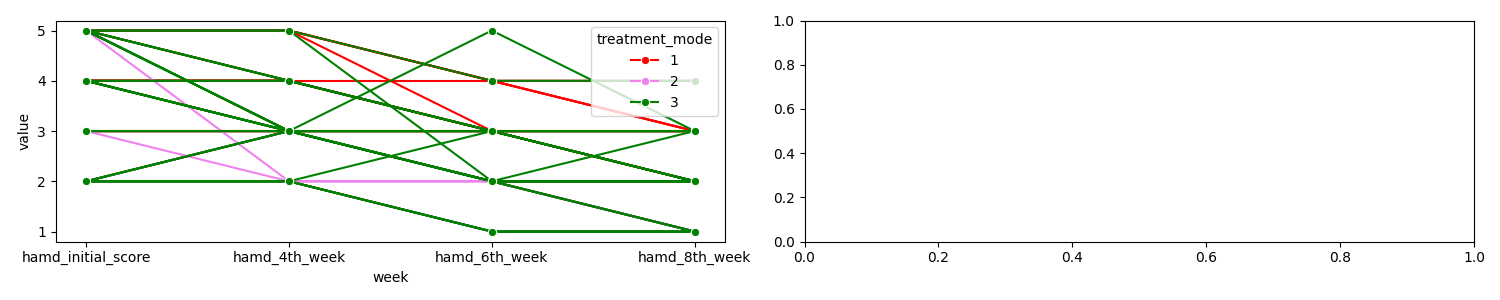

In [196]:
treatment_timeline_fig, (hamd_ax, phq9_ax) = plt.subplots(1,2, figsize=(15,3))

timeline_weeks = [0, 2, 4, 6, 8]

sns.lineplot(data=hamd_timeline_long, x='week', y='value', units='id', hue='treatment_mode', estimator=None, ax=hamd_ax, marker='o',
             palette=['red', 'violet', 'green'])

treatment_timeline_fig.tight_layout()
treatment_timeline_fig.savefig("figures/HAMD & PHQ9 Score Timeline Over Different Treatment Modalities.png", dpi=300)

In [154]:
plt.close("all")